# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. I'll compute the camera calibration using chessboard images

Find the object points and image points for the calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## 2. Apply Distortion Correction to Raw Images

Now we have objpoints and imgpoints of the camera and we will use it for the next step, calibration and undistortion


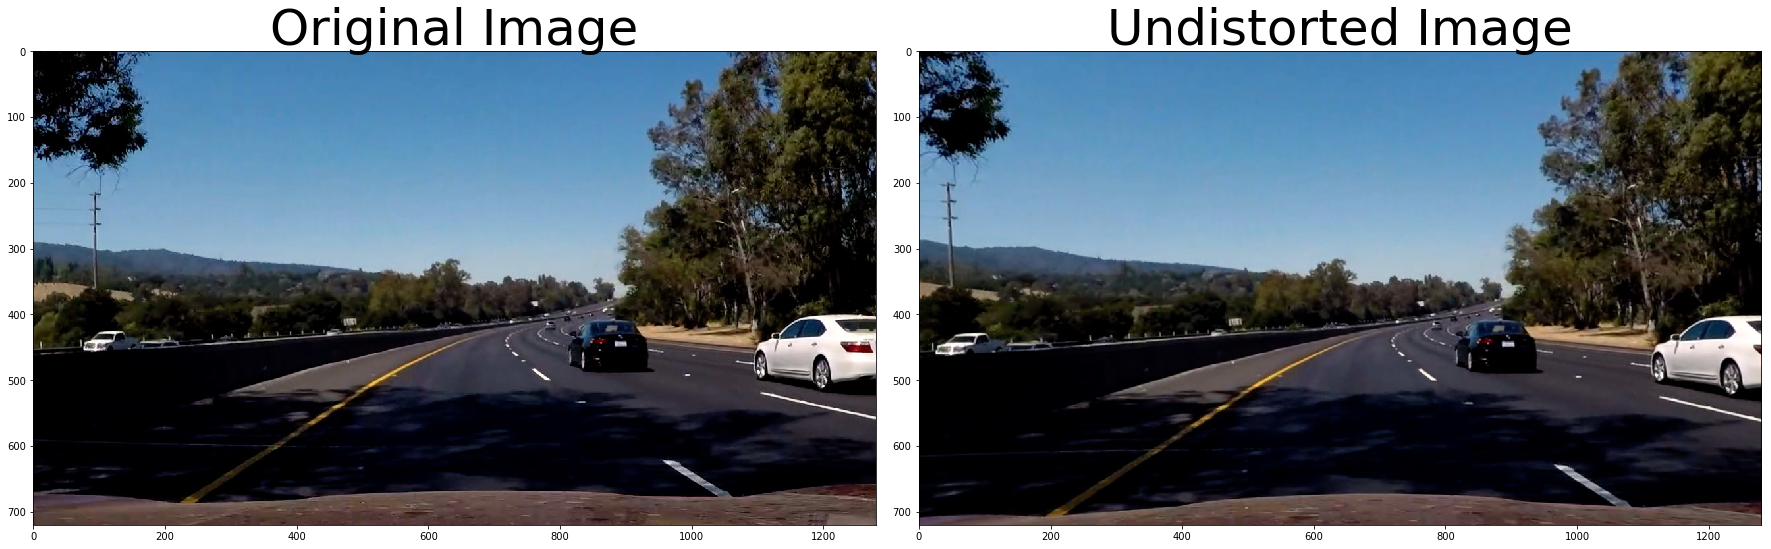

In [401]:
import matplotlib.image as mpimg

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(dst)  # Delete this line
    return undist

img = cv2.imread('/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/test_images/my_test10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

undistorted = cal_undistort(img, objpoints, imgpoints)

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistort_output.png')


## 3. Use Color Transforms, Gradients, etc., to create a thresholded binary image.

Now we are going to get the gradient in x axis and y axis and combine with HLS 

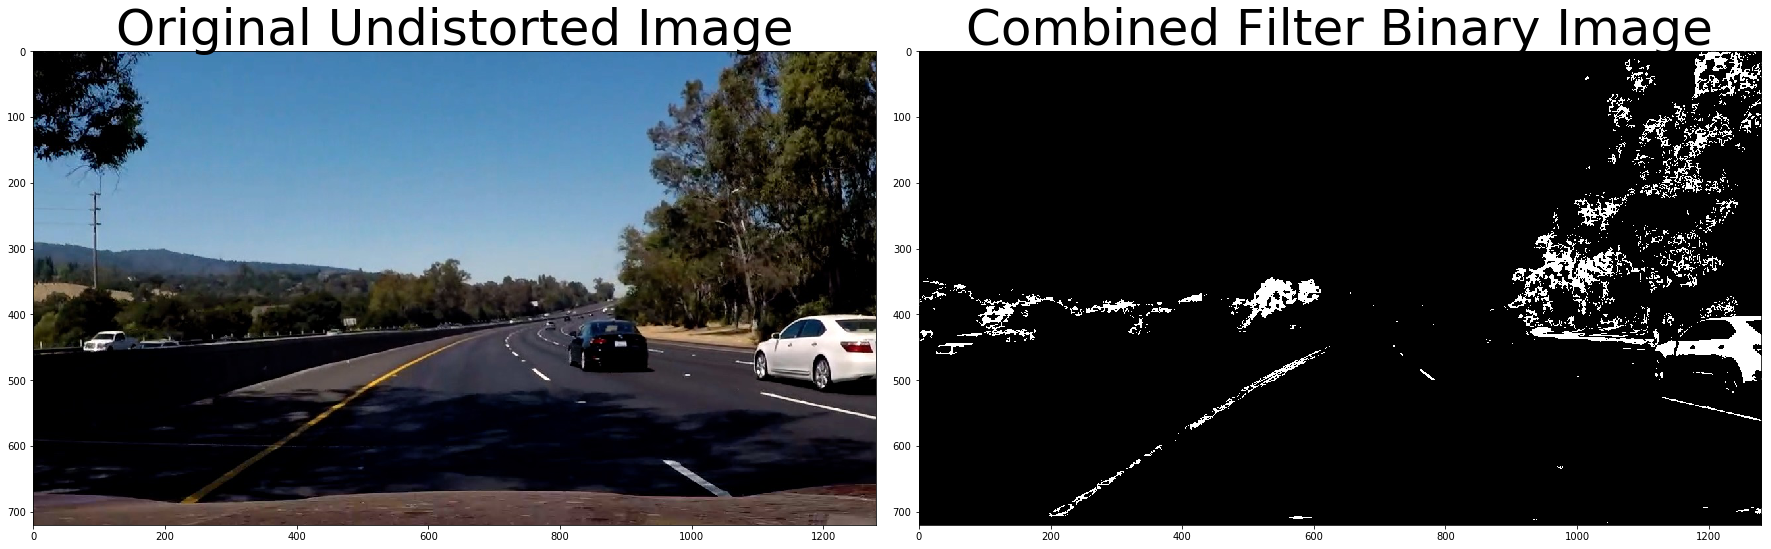

In [402]:
def combine_select(img, Sthresh=(0, 255), mag_thresh=(0, 255), sobel_kernel=3):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #H = hls[:,:,0]
    #L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_S = np.zeros_like(S)
    binary_S[(S > Sthresh[0]) & (S <= Sthresh[1])] = 1
    
    
    Lthresh = (220,255)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = luv[:,:,0]
    binary_L = np.zeros_like(L)
    binary_L[(L > Lthresh[0]) & (L <= Lthresh[1])] = 1
    
    Bthresh = (135,200)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = lab[:,:,2]
    binary_B = np.zeros_like(B)
    binary_B[(B > Bthresh[0]) & (B <= Bthresh[1])] = 1
    
    
    
    
    # 3) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 4) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 5) Calculate the magnitude 
    sobel = np.sqrt(sobelx**2 + sobely**2)
    #sobel = sobelx
    #sobel = sobely
    # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 7) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    combined_binary = np.zeros_like(sbinary)
    combined_binary[((binary_B == 1) & (binary_S == 1))|(binary_L == 1)] = 1
    
    # 8) Return a binary image of threshold result
    binary_output = np.copy(combined_binary) # placeholder line
    #binary_output = np.copy(sbinary) # placeholder line
    return binary_output
    
combine_binary = combine_select(undistorted, Sthresh=(90, 150), mag_thresh=(70, 255))
#result_path = '/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/output_images/test_out.jpg'

#cv2.imwrite(result_path,combine_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Undistorted Image', fontsize=50)
ax2.imshow(combine_binary, cmap='gray')
ax2.set_title('Combined Filter Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/gradient_binary_result.png')



## 3. Apply a Perspective Transform to Rectify Binary Image

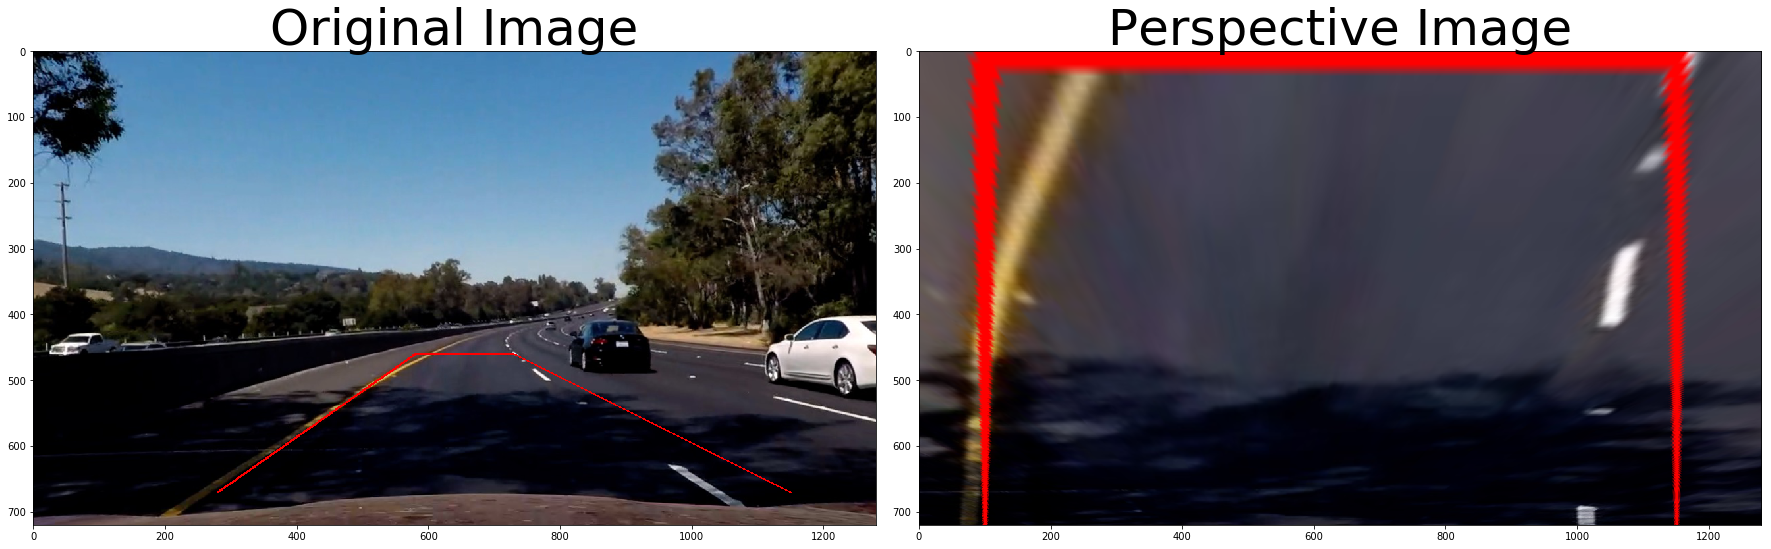

In [403]:
point_left_up = (580, 460)
point_left_down = (280, 670)
point_right_up = (730, 460)
point_right_down = (1150, 670)

src = np.float32([point_left_up, point_left_down, point_right_down, point_right_up])
dst = np.float32([(100, 0), (100, 720), (1150, 720), (1150, 0)])

M = cv2.getPerspectiveTransform(src, dst)   
img_size = (combine_binary.shape[1],combine_binary.shape[0])
   
            
#delete the next two lines
undistorted_drawlines = np.copy(undistorted) 
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


cv2.line(undistorted_drawlines,point_left_up, point_left_down, (255,0,0), 2)
cv2.line(undistorted_drawlines,point_right_down, point_right_up, (255,0,0), 2)
cv2.line(undistorted_drawlines,point_left_up, point_right_up, (255,0,0), 2)


warped = cv2.warpPerspective(undistorted_drawlines, M, img_size, flags=cv2.INTER_LINEAR)

ax1.imshow(undistorted_drawlines)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Perspective Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_result.png')

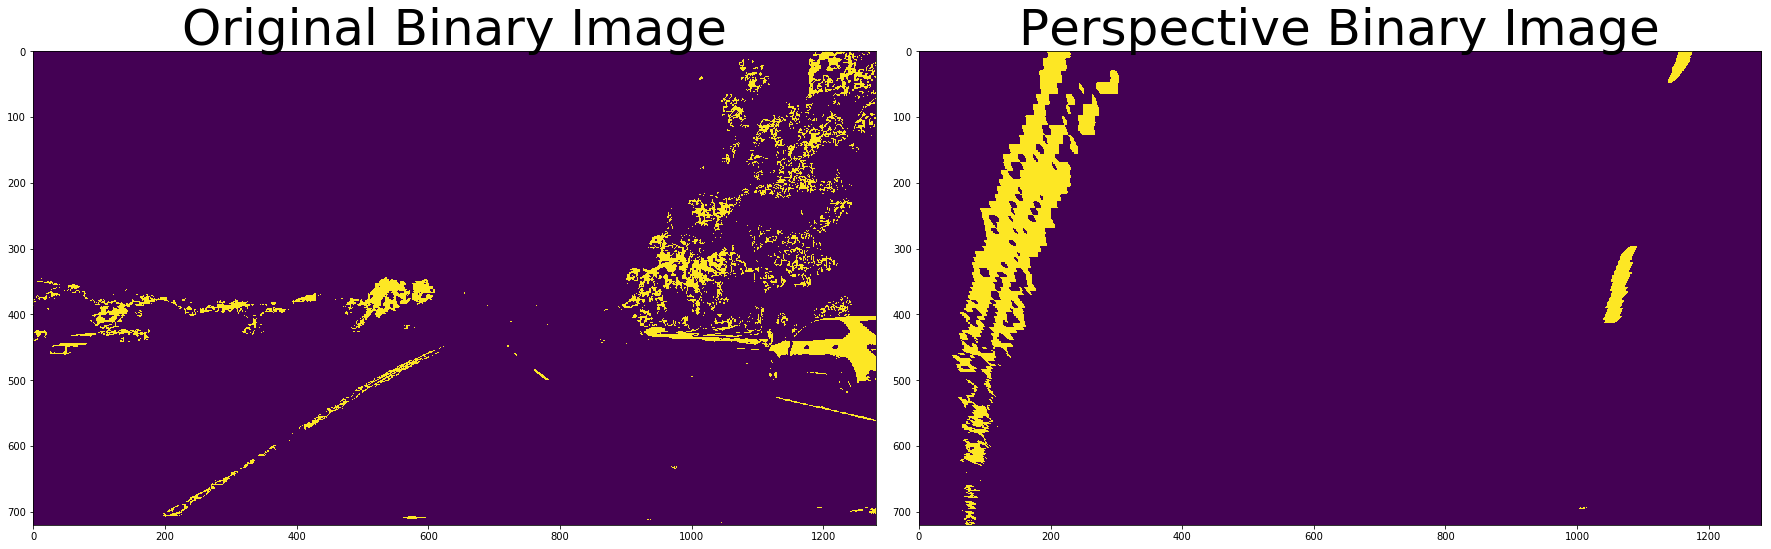

In [404]:
#delete the next two lines
combine_binary_drawlines = np.copy(combine_binary) 
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


#cv2.line(combine_binary_drawlines,point_left_up, point_left_down, (255,0,0), 2)
#cv2.line(combine_binary_drawlines,point_right_down, point_right_up, (255,0,0), 2)
#cv2.line(combine_binary_drawlines,point_left_up, point_right_up, (255,0,0), 2)


warped_binary = cv2.warpPerspective(combine_binary, M, img_size, flags=cv2.INTER_LINEAR)

ax1.imshow(combine_binary_drawlines)
ax1.set_title('Original Binary Image', fontsize=50)
ax2.imshow(warped_binary)
ax2.set_title('Perspective Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_result2.png')

## 4. Detect Lane Pixels and Fit to Find The Lane Boundary.

537.5


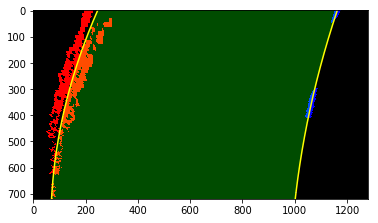

In [405]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
     
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        ### (`right` or `leftx_current`) on their mean position ###

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    
    line_pts = np.hstack((line_window1, line_window2))
    window_img = np.zeros_like(out_img)
     # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    center_of_lane = (leftx[0]+rightx)/2
    

    return result, center_of_lane[0]


out_img, center_of_lane = fit_polynomial(warped_binary)
print(center_of_lane)

plt.imshow(out_img)
plt.savefig('output_images/Lane_Pixel_Result.png')

## 5. Determine The Curvature of the Lane and Vehicle Position with Respect to Center.

In [398]:
def fit_polynomial_curve(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return ploty, left_fit, right_fit


def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = fit_polynomial_curve(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    
    
    return left_curverad, right_curverad



# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(warped_binary)


print(left_curverad, 'm', right_curverad, 'm')

1488.6332453796426 m 2879.66577725656 m


## 6. Warp the Detected Lane Boundaries Back onto The Original Image.

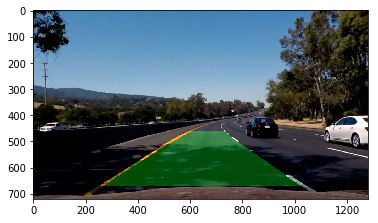

In [409]:
Minv = cv2.getPerspectiveTransform(dst, src)
wrap_img = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_LINEAR)
wrap_result = cv2.addWeighted(undistorted, 1, wrap_img, 1, 0)
plt.imshow(wrap_result)
plt.savefig('output_images/Example_Result.png')

## 7. Output Visual Display of the Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position.

In [304]:
result = cv2.addWeighted(undistorted,1,wrap_img,1,0) 
offset = 25
cv2.putText(result,'Vehicle is' + str(round(offset,3))+'m'+side_pos+'of center',
            (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
cv2.putText(result,'Radius of curvature:'+str(round((left_curverad + right_curverad)/2))+'m',
            (50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2) 

plt.imshow(result)

NameError: name 'side_pos' is not defined

## 8. Now we build the pipeline and output processed image and save into the output_image folder

True

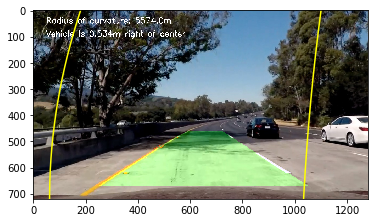

In [395]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combine_binary = hls_select(undistorted, Sthresh=(140, 255), mag_thresh=(70, 255))
    M = cv2.getPerspectiveTransform(src, dst)   
    img_size = (combine_binary.shape[1],combine_binary.shape[0])
    warped = cv2.warpPerspective(combine_binary, M, img_size, flags=cv2.INTER_LINEAR)   

    out_img, center_of_lane = fit_polynomial(warped)
    left_curverad, right_curverad = measure_curvature_pixels(warped)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    wrap_img = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted,1,wrap_img,1,0) 
    
    xm_per_pix = xm_per_pix = 3.7/700
    offset = (img_size[0]/2 - center_of_lane)*xm_per_pix
 

    side_pos = 'right'
    if offset <0:
        side_pos = 'left'
    
    cv2.putText(result,'Vehicle is ' + str(round(abs(offset),3))+'m '+side_pos+' of center',
            (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
    cv2.putText(result,'Radius of curvature: '+str(round((left_curverad + right_curverad)/2))+'m',
            (50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2) 
    return result


img = cv2.imread('/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
xxx = pipeline(img)
plt.imshow(xxx)
    
xxxx = cv2.cvtColor(xxx, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines2_out.jpg',xxxx)



## 9. Use the pipeline to process the project_video.mp4 and save the output into the output image folder
From the output video, this algorithms and parameters can do a very good job for the source video.

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<05:41,  3.69it/s]



  0%|          | 2/1261 [00:00<05:42,  3.67it/s]



  0%|          | 3/1261 [00:00<05:39,  3.71it/s]



  0%|          | 4/1261 [00:01<05:38,  3.71it/s]



  0%|          | 5/1261 [00:01<05:29,  3.81it/s]



  0%|          | 6/1261 [00:01<05:56,  3.52it/s]



  1%|          | 7/1261 [00:01<05:44,  3.64it/s]



  1%|          | 8/1261 [00:02<05:32,  3.77it/s]



  1%|          | 9/1261 [00:02<05:24,  3.86it/s]



  1%|          | 10/1261 [00:02<05:19,  3.91it/s]



  1%|          | 11/1261 [00:02<05:17,  3.93it/s]



  1%|          | 12/1261 [00:03<05:14,  3.97it/s]



  1%|          | 13/1261 [00:03<05:13,  3.98it/s]



  1%|          | 14/1261 [00:03<05:12,  3.99it/s]



  1%|          | 15/1261 [00:03<05:08,  4.04it/s]



  1%|▏         | 16/1261 [00:04<05:06,  4.07it/s]



  1%|▏         | 17/1261 [00:04<05:06,  4.06it/s]



  1%|▏         | 18/1261 [00:04<05:08,  4.03it/s]



  2%|▏ 

 10%|▉         | 125/1261 [00:32<05:01,  3.77it/s]



 10%|▉         | 126/1261 [00:32<05:03,  3.74it/s]



 10%|█         | 127/1261 [00:33<04:56,  3.82it/s]



 10%|█         | 128/1261 [00:33<04:51,  3.89it/s]



 10%|█         | 129/1261 [00:33<04:48,  3.92it/s]



 10%|█         | 130/1261 [00:33<04:47,  3.93it/s]



 10%|█         | 131/1261 [00:34<04:48,  3.92it/s]



 10%|█         | 132/1261 [00:34<04:46,  3.94it/s]



 11%|█         | 133/1261 [00:34<04:42,  3.99it/s]



 11%|█         | 134/1261 [00:34<04:41,  4.01it/s]



 11%|█         | 135/1261 [00:35<04:40,  4.02it/s]



 11%|█         | 136/1261 [00:35<04:39,  4.03it/s]



 11%|█         | 137/1261 [00:35<04:39,  4.02it/s]



 11%|█         | 138/1261 [00:35<04:38,  4.04it/s]



 11%|█         | 139/1261 [00:36<04:40,  4.01it/s]



 11%|█         | 140/1261 [00:36<04:39,  4.01it/s]



 11%|█         | 141/1261 [00:36<04:38,  4.02it/s]



 11%|█▏        | 142/1261 [00:36<04:37,  4.03it/s]



 11%|█▏        | 143/1261 [0

 20%|█▉        | 249/1261 [01:04<04:17,  3.94it/s]



 20%|█▉        | 250/1261 [01:04<04:26,  3.79it/s]



 20%|█▉        | 251/1261 [01:04<04:24,  3.82it/s]



 20%|█▉        | 252/1261 [01:04<04:23,  3.83it/s]



 20%|██        | 253/1261 [01:05<04:22,  3.83it/s]



 20%|██        | 254/1261 [01:05<04:34,  3.67it/s]



 20%|██        | 255/1261 [01:05<04:39,  3.59it/s]



 20%|██        | 256/1261 [01:06<04:45,  3.51it/s]



 20%|██        | 257/1261 [01:06<04:37,  3.62it/s]



 20%|██        | 258/1261 [01:06<04:28,  3.74it/s]



 21%|██        | 259/1261 [01:06<04:26,  3.76it/s]



 21%|██        | 260/1261 [01:07<04:23,  3.80it/s]



 21%|██        | 261/1261 [01:07<04:20,  3.85it/s]



 21%|██        | 262/1261 [01:07<04:16,  3.89it/s]



 21%|██        | 263/1261 [01:07<04:27,  3.73it/s]



 21%|██        | 264/1261 [01:08<04:25,  3.75it/s]



 21%|██        | 265/1261 [01:08<04:19,  3.84it/s]



 21%|██        | 266/1261 [01:08<04:17,  3.86it/s]



 21%|██        | 267/1261 [0

 30%|██▉       | 373/1261 [01:37<03:44,  3.95it/s]



 30%|██▉       | 374/1261 [01:37<03:45,  3.93it/s]



 30%|██▉       | 375/1261 [01:37<03:43,  3.97it/s]



 30%|██▉       | 376/1261 [01:38<03:40,  4.02it/s]



 30%|██▉       | 377/1261 [01:38<03:37,  4.06it/s]



 30%|██▉       | 378/1261 [01:38<03:38,  4.05it/s]



 30%|███       | 379/1261 [01:38<03:37,  4.05it/s]



 30%|███       | 380/1261 [01:39<03:37,  4.04it/s]



 30%|███       | 381/1261 [01:39<03:36,  4.06it/s]



 30%|███       | 382/1261 [01:39<03:37,  4.03it/s]



 30%|███       | 383/1261 [01:39<03:38,  4.02it/s]



 30%|███       | 384/1261 [01:40<03:38,  4.02it/s]



 31%|███       | 385/1261 [01:40<03:37,  4.02it/s]



 31%|███       | 386/1261 [01:40<03:38,  4.01it/s]



 31%|███       | 387/1261 [01:40<03:35,  4.05it/s]



 31%|███       | 388/1261 [01:41<03:34,  4.06it/s]



 31%|███       | 389/1261 [01:41<03:33,  4.08it/s]



 31%|███       | 390/1261 [01:41<03:34,  4.07it/s]



 31%|███       | 391/1261 [0

 39%|███▉      | 497/1261 [02:09<03:31,  3.61it/s]



 39%|███▉      | 498/1261 [02:09<03:37,  3.52it/s]



 40%|███▉      | 499/1261 [02:09<03:32,  3.59it/s]



 40%|███▉      | 500/1261 [02:10<03:31,  3.59it/s]



 40%|███▉      | 501/1261 [02:10<03:27,  3.66it/s]



 40%|███▉      | 502/1261 [02:10<03:29,  3.61it/s]



 40%|███▉      | 503/1261 [02:11<03:27,  3.65it/s]



 40%|███▉      | 504/1261 [02:11<03:23,  3.71it/s]



 40%|████      | 505/1261 [02:11<03:22,  3.73it/s]



 40%|████      | 506/1261 [02:11<03:19,  3.79it/s]



 40%|████      | 507/1261 [02:12<03:16,  3.83it/s]



 40%|████      | 508/1261 [02:12<03:12,  3.91it/s]



 40%|████      | 509/1261 [02:12<03:13,  3.88it/s]



 40%|████      | 510/1261 [02:12<03:14,  3.86it/s]



 41%|████      | 511/1261 [02:13<03:12,  3.90it/s]



 41%|████      | 512/1261 [02:13<03:12,  3.90it/s]



 41%|████      | 513/1261 [02:13<03:10,  3.92it/s]



 41%|████      | 514/1261 [02:13<03:13,  3.86it/s]



 41%|████      | 515/1261 [0

 49%|████▉     | 621/1261 [02:41<02:41,  3.96it/s]



 49%|████▉     | 622/1261 [02:41<02:41,  3.97it/s]



 49%|████▉     | 623/1261 [02:42<02:41,  3.96it/s]



 49%|████▉     | 624/1261 [02:42<02:40,  3.96it/s]



 50%|████▉     | 625/1261 [02:42<02:49,  3.76it/s]



 50%|████▉     | 626/1261 [02:43<02:56,  3.59it/s]



 50%|████▉     | 627/1261 [02:43<02:50,  3.71it/s]



 50%|████▉     | 628/1261 [02:43<02:54,  3.63it/s]



 50%|████▉     | 629/1261 [02:43<02:56,  3.59it/s]



 50%|████▉     | 630/1261 [02:44<02:52,  3.66it/s]



 50%|█████     | 631/1261 [02:44<02:52,  3.66it/s]



 50%|█████     | 632/1261 [02:44<02:48,  3.74it/s]



 50%|█████     | 633/1261 [02:44<02:43,  3.84it/s]



 50%|█████     | 634/1261 [02:45<02:43,  3.83it/s]



 50%|█████     | 635/1261 [02:45<02:39,  3.91it/s]



 50%|█████     | 636/1261 [02:45<02:38,  3.93it/s]



 51%|█████     | 637/1261 [02:45<02:36,  3.98it/s]



 51%|█████     | 638/1261 [02:46<02:37,  3.95it/s]



 51%|█████     | 639/1261 [0

 59%|█████▉    | 745/1261 [03:13<02:14,  3.83it/s]



 59%|█████▉    | 746/1261 [03:13<02:15,  3.81it/s]



 59%|█████▉    | 747/1261 [03:14<02:13,  3.84it/s]



 59%|█████▉    | 748/1261 [03:14<02:13,  3.85it/s]



 59%|█████▉    | 749/1261 [03:14<02:12,  3.88it/s]



 59%|█████▉    | 750/1261 [03:14<02:12,  3.85it/s]



 60%|█████▉    | 751/1261 [03:15<02:11,  3.89it/s]



 60%|█████▉    | 752/1261 [03:15<02:10,  3.91it/s]



 60%|█████▉    | 753/1261 [03:15<02:10,  3.89it/s]



 60%|█████▉    | 754/1261 [03:15<02:09,  3.92it/s]



 60%|█████▉    | 755/1261 [03:16<02:09,  3.91it/s]



 60%|█████▉    | 756/1261 [03:16<02:09,  3.91it/s]



 60%|██████    | 757/1261 [03:16<02:07,  3.95it/s]



 60%|██████    | 758/1261 [03:16<02:08,  3.92it/s]



 60%|██████    | 759/1261 [03:17<02:07,  3.95it/s]



 60%|██████    | 760/1261 [03:17<02:05,  3.98it/s]



 60%|██████    | 761/1261 [03:17<02:04,  4.01it/s]



 60%|██████    | 762/1261 [03:17<02:05,  3.98it/s]



 61%|██████    | 763/1261 [0

 69%|██████▉   | 869/1261 [03:45<01:43,  3.80it/s]



 69%|██████▉   | 870/1261 [03:45<01:42,  3.83it/s]



 69%|██████▉   | 871/1261 [03:46<01:41,  3.85it/s]



 69%|██████▉   | 872/1261 [03:46<01:40,  3.87it/s]



 69%|██████▉   | 873/1261 [03:46<01:39,  3.90it/s]



 69%|██████▉   | 874/1261 [03:46<01:40,  3.87it/s]



 69%|██████▉   | 875/1261 [03:47<01:40,  3.84it/s]



 69%|██████▉   | 876/1261 [03:47<01:40,  3.82it/s]



 70%|██████▉   | 877/1261 [03:47<01:41,  3.77it/s]



 70%|██████▉   | 878/1261 [03:47<01:40,  3.81it/s]



 70%|██████▉   | 879/1261 [03:48<01:38,  3.86it/s]



 70%|██████▉   | 880/1261 [03:48<01:41,  3.75it/s]



 70%|██████▉   | 881/1261 [03:48<01:42,  3.72it/s]



 70%|██████▉   | 882/1261 [03:49<01:43,  3.65it/s]



 70%|███████   | 883/1261 [03:49<01:41,  3.73it/s]



 70%|███████   | 884/1261 [03:49<01:40,  3.75it/s]



 70%|███████   | 885/1261 [03:49<01:40,  3.75it/s]



 70%|███████   | 886/1261 [03:50<01:39,  3.79it/s]



 70%|███████   | 887/1261 [0

 79%|███████▊  | 993/1261 [04:17<01:08,  3.93it/s]



 79%|███████▉  | 994/1261 [04:17<01:10,  3.79it/s]



 79%|███████▉  | 995/1261 [04:18<01:09,  3.82it/s]



 79%|███████▉  | 996/1261 [04:18<01:08,  3.87it/s]



 79%|███████▉  | 997/1261 [04:18<01:08,  3.88it/s]



 79%|███████▉  | 998/1261 [04:18<01:08,  3.86it/s]



 79%|███████▉  | 999/1261 [04:19<01:08,  3.83it/s]



 79%|███████▉  | 1000/1261 [04:19<01:06,  3.91it/s]



 79%|███████▉  | 1001/1261 [04:19<01:06,  3.94it/s]



 79%|███████▉  | 1002/1261 [04:19<01:06,  3.91it/s]



 80%|███████▉  | 1003/1261 [04:20<01:05,  3.97it/s]



 80%|███████▉  | 1004/1261 [04:20<01:05,  3.91it/s]



 80%|███████▉  | 1005/1261 [04:20<01:06,  3.86it/s]



 80%|███████▉  | 1006/1261 [04:20<01:06,  3.82it/s]



 80%|███████▉  | 1007/1261 [04:21<01:05,  3.86it/s]



 80%|███████▉  | 1008/1261 [04:21<01:05,  3.88it/s]



 80%|████████  | 1009/1261 [04:21<01:15,  3.33it/s]



 80%|████████  | 1010/1261 [04:22<01:12,  3.46it/s]



 80%|████████  | 

 88%|████████▊ | 1115/1261 [04:48<00:37,  3.92it/s]



 89%|████████▊ | 1116/1261 [04:49<00:36,  3.92it/s]



 89%|████████▊ | 1117/1261 [04:49<00:36,  3.92it/s]



 89%|████████▊ | 1118/1261 [04:49<00:36,  3.90it/s]



 89%|████████▊ | 1119/1261 [04:49<00:36,  3.92it/s]



 89%|████████▉ | 1120/1261 [04:50<00:35,  3.97it/s]



 89%|████████▉ | 1121/1261 [04:50<00:35,  3.98it/s]



 89%|████████▉ | 1122/1261 [04:50<00:34,  3.99it/s]



 89%|████████▉ | 1123/1261 [04:50<00:34,  3.98it/s]



 89%|████████▉ | 1124/1261 [04:51<00:34,  3.94it/s]



 89%|████████▉ | 1125/1261 [04:51<00:35,  3.88it/s]



 89%|████████▉ | 1126/1261 [04:51<00:35,  3.84it/s]



 89%|████████▉ | 1127/1261 [04:51<00:34,  3.87it/s]



 89%|████████▉ | 1128/1261 [04:52<00:34,  3.85it/s]



 90%|████████▉ | 1129/1261 [04:52<00:34,  3.81it/s]



 90%|████████▉ | 1130/1261 [04:52<00:34,  3.81it/s]



 90%|████████▉ | 1131/1261 [04:53<00:34,  3.76it/s]



 90%|████████▉ | 1132/1261 [04:53<00:34,  3.74it/s]



 90%|█████

 98%|█████████▊| 1237/1261 [05:20<00:06,  3.62it/s]



 98%|█████████▊| 1238/1261 [05:21<00:06,  3.71it/s]



 98%|█████████▊| 1239/1261 [05:21<00:05,  3.80it/s]



 98%|█████████▊| 1240/1261 [05:21<00:05,  3.84it/s]



 98%|█████████▊| 1241/1261 [05:21<00:05,  3.84it/s]



 98%|█████████▊| 1242/1261 [05:22<00:04,  3.89it/s]



 99%|█████████▊| 1243/1261 [05:22<00:04,  3.90it/s]



 99%|█████████▊| 1244/1261 [05:22<00:04,  3.90it/s]



 99%|█████████▊| 1245/1261 [05:22<00:04,  3.91it/s]



 99%|█████████▉| 1246/1261 [05:23<00:03,  3.93it/s]



 99%|█████████▉| 1247/1261 [05:23<00:03,  3.94it/s]



 99%|█████████▉| 1248/1261 [05:23<00:03,  3.95it/s]



 99%|█████████▉| 1249/1261 [05:23<00:03,  3.95it/s]



 99%|█████████▉| 1250/1261 [05:24<00:02,  3.95it/s]



 99%|█████████▉| 1251/1261 [05:24<00:02,  3.95it/s]



 99%|█████████▉| 1252/1261 [05:24<00:02,  3.94it/s]



 99%|█████████▉| 1253/1261 [05:25<00:02,  3.91it/s]



 99%|█████████▉| 1254/1261 [05:25<00:01,  3.69it/s]



100%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 12min 7s, sys: 1min 48s, total: 13min 55s
Wall time: 5min 27s


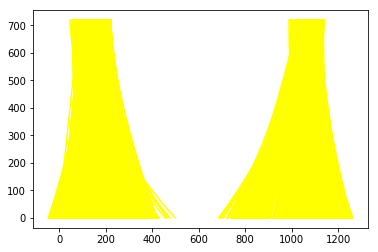

In [396]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

white_output = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## 10. Use the pipeline to process the challenge_video.mp4 and save the output into the output image folder
My algorithms does not do a good job for the 2 challenge videos, I think I just need to adjust parameters.

[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:58,  4.07it/s]

  0%|          | 2/485 [00:00<01:59,  4.05it/s]

  1%|          | 3/485 [00:00<02:02,  3.93it/s]

  1%|          | 4/485 [00:01<01:59,  4.02it/s]

  1%|          | 5/485 [00:01<01:57,  4.08it/s]

TypeError: expected non-empty vector for x

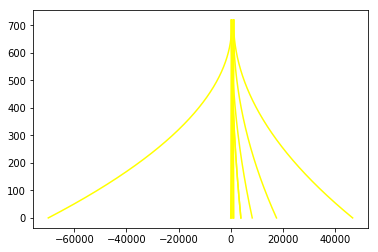

In [307]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

white_output = 'output_images/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## 11. Use the pipeline to process the challenge_video.mp4 and save the output into the output image folder


[MoviePy] >>>> Building video output_images/harder_challenge_video_output.mp4
[MoviePy] Writing video output_images/harder_challenge_video_output.mp4





  0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 1/1200 [00:00<05:39,  3.53it/s]


  0%|          | 2/1200 [00:00<05:30,  3.62it/s]


  0%|          | 3/1200 [00:00<05:26,  3.66it/s]


  0%|          | 4/1200 [00:01<05:17,  3.77it/s]


  0%|          | 5/1200 [00:01<05:12,  3.83it/s]


  0%|          | 6/1200 [00:01<05:08,  3.87it/s]


  1%|          | 7/1200 [00:01<05:06,  3.90it/s]


  1%|          | 8/1200 [00:02<05:04,  3.92it/s]


  1%|          | 9/1200 [00:02<05:03,  3.92it/s]


  1%|          | 10/1200 [00:02<05:03,  3.92it/s]


  1%|          | 11/1200 [00:02<05:03,  3.92it/s]


  1%|          | 12/1200 [00:03<05:04,  3.90it/s]


  1%|          | 13/1200 [00:03<05:05,  3.88it/s]


  1%|          | 14/1200 [00:03<05:05,  3.89it/s]


  1%|▏         | 15/1200 [00:03<05:08,  3.85it/s]


  1%|▏         | 16/1200 [00:04<05:07,  3.85it/s]


  1%|▏         | 17/1200 [00:04<05:02,  3.91it/s]


  2%|▏         | 18/1200 [00:04<05:03,  3.89it/s]


  2%|▏         | 19/1200 [0

 11%|█         | 134/1200 [00:34<04:36,  3.86it/s]


 11%|█▏        | 135/1200 [00:35<04:34,  3.88it/s]


 11%|█▏        | 136/1200 [00:35<04:35,  3.86it/s]


 11%|█▏        | 137/1200 [00:35<04:34,  3.87it/s]


 12%|█▏        | 138/1200 [00:35<04:32,  3.90it/s]


 12%|█▏        | 139/1200 [00:36<04:31,  3.91it/s]


 12%|█▏        | 140/1200 [00:36<04:33,  3.88it/s]


 12%|█▏        | 141/1200 [00:36<04:31,  3.90it/s]


 12%|█▏        | 142/1200 [00:36<04:30,  3.91it/s]


 12%|█▏        | 143/1200 [00:37<04:31,  3.90it/s]


 12%|█▏        | 144/1200 [00:37<04:32,  3.87it/s]


 12%|█▏        | 145/1200 [00:37<04:36,  3.82it/s]


 12%|█▏        | 146/1200 [00:37<04:37,  3.79it/s]


 12%|█▏        | 147/1200 [00:38<04:38,  3.78it/s]


 12%|█▏        | 148/1200 [00:38<04:38,  3.77it/s]


 12%|█▏        | 149/1200 [00:38<04:39,  3.76it/s]


 12%|█▎        | 150/1200 [00:38<04:37,  3.78it/s]


 13%|█▎        | 151/1200 [00:39<04:35,  3.81it/s]


 13%|█▎        | 152/1200 [00:39<04:36,  3.79i

TypeError: expected non-empty vector for x

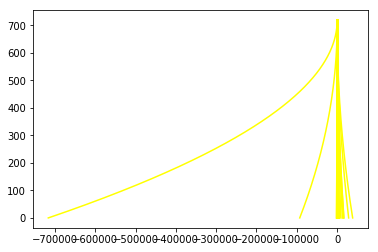

In [308]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

white_output = 'output_images/harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)